**Installing Dependencies for Detectron2 + Imports Common Libraries**

**Make sure to use Google Colab - T4 GPU in Runtime Settings**

In [1]:
!nvidia-smi

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

Wed Oct 11 19:03:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Download Dataset from Roboflow**

In [1]:
API_KEY = __INSERT_API_KEY_HERE__

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=API_KEY)
project = rf.workspace("stevens-institute-of-technology-aai800").project("bee-detection-aqdkr")
dataset = project.version(1).download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Bee-Detection-1 in coco:: 100%|██████████| 3052/3052 [00:00<00:00, 3654.99it/s]


**Register Detectron2 Before Using**

In [2]:
dataset.location

'/content/Bee-Detection-1'

In [3]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['Bee-Detection-train', 'Bee-Detection-test', 'Bee-Detection-valid']

**Visualize Training Data**

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



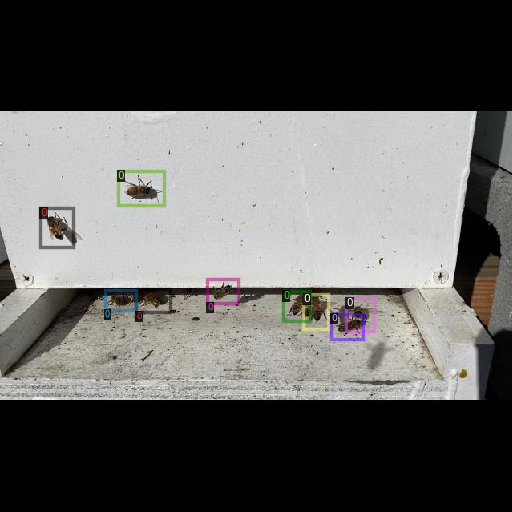

In [4]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

**Train Faster-R-CNN Model Using Custom COCO Format Dataset**

In [6]:
# HYPERPARAMETERS
# https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml
ARCHITECTURE = "faster_rcnn_X_101_32x8d_FPN_3x"
CONFIG_FILE_PATH = f"COCO-Detection/{ARCHITECTURE}.yaml"
MAX_ITER = 2000
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 3

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME,
    ARCHITECTURE,
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/11 19:33:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:03, 140MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/11 19:33:57 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


[10/11 19:34:21 d2.utils.events]:  eta: 0:36:12  iter: 19  total_loss: 2.933  loss_cls: 1.574  loss_box_reg: 0.8878  loss_rpn_cls: 0.4212  loss_rpn_loc: 0.04988    time: 1.0437  last_time: 0.9733  data_time: 0.0189  last_data_time: 0.0190   lr: 1.9981e-05  max_mem: 3883M
[10/11 19:34:46 d2.utils.events]:  eta: 0:35:56  iter: 39  total_loss: 2.286  loss_cls: 1.205  loss_box_reg: 0.9436  loss_rpn_cls: 0.1117  loss_rpn_loc: 0.06824    time: 1.0772  last_time: 1.2355  data_time: 0.0096  last_data_time: 0.0172   lr: 3.9961e-05  max_mem: 3885M
[10/11 19:35:08 d2.utils.events]:  eta: 0:35:38  iter: 59  total_loss: 1.883  loss_cls: 0.8571  loss_box_reg: 0.9437  loss_rpn_cls: 0.03212  loss_rpn_loc: 0.03621    time: 1.0900  last_time: 1.2519  data_time: 0.0110  last_data_time: 0.0078   lr: 5.9941e-05  max_mem: 3885M
[10/11 19:35:31 d2.utils.events]:  eta: 0:35:20  iter: 79  total_loss: 1.642  loss_cls: 0.6222  loss_box_reg: 0.9415  loss_rpn_cls: 0.02835  loss_rpn_loc: 0.03647    time: 1.0943  la

**Testing and Evaluation**

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

dataset_valid = DatasetCatalog.get(VALID_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_RBG
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

**Testing Dataset**

In [11]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("Bee-Detection-test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "Bee-Detection-test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[10/11 20:34:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Bee-Detection/faster_rcnn_X_101_32x8d_FPN_3x/2023-10-11-19-33-51/model_final.pth ...
WARNING [10/11 20:34:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [10/11 20:34:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/11 20:34:10 d2.data.datasets.coco]: Loaded 304 images in COCO format from /content/Bee-Detection-1/test/_annotations.coco.json
[10/11 20:34:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/11 20:34:10 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/11 20:34:10 d2.data.common]: Serializing 304 elements to byte tensors and concatenati

OrderedDict([('bbox',
              {'AP': 48.46794277895475,
               'AP50': 90.52402702079789,
               'AP75': 47.708872836177406,
               'APs': 35.96446000822986,
               'APm': 51.50975588384219,
               'APl': 54.124093478878244,
               'AP-Bees': nan,
               'AP-0': 48.46794277895475})])

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

dataset_test = DatasetCatalog.get(TEST_DATA_SET_NAME)

for d in dataset_test:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])